![Tanque%20de%20Resfriamento.png](../assets/TanqueDeResfriamento.png)
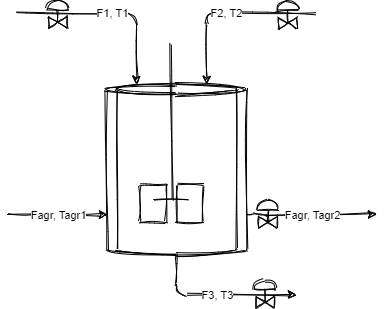

### EDO 1:

$$ {dh \over dt} = {1 \over A}[{F_1 (t)} + {F_2 (t)} - {F_3 (t)}] $$

### EDO 2:

$$ {dT_3 \over dt} = {1 \over Ah} \biggr (-T_3 (F_1 + F_2)
+ F_1 T_1 + F_2 T_2 - {UA_{tt} \over \rho Cp}(T_3 - T_{agr_2})\biggl) $$

### EDO 3:

$$ {dT_{agr_2} \over dt} = {1 \over V_c} \biggr(F_{agr}(T_{agr_1} - T_{agr_2}) 
+ {UA_{tt} \over \rho Cp}(T_3 - T_{agr_2}) \biggl) $$

In [619]:
#Hipóteses:
#CSTR e Tanque Cilíndrico
#Densidade constante para os fluidos da camisa e do tanque (mesmo fluido)
#Volume da camisa constante e completamente cheia ---> Fagr1 = Fagr2 = Fagr
#Cp fluido da camisa = Cp fluido do tanque
#Energia potencial e cinética desprezíveis frente à energia interna

In [644]:
import numpy as np                     #biblioteca p/ manipulação de vetores
import matplotlib.pyplot as plt        #biblioteca gráfica
from scipy.integrate import odeint     #biblioteca que contém o ODE solver/ ODE solver importado

#O nome das variáveis e o que elas representam seguem o mesmo do modelo apresentado em aula.

#----------------Parâmetros
A = 10 #10 #m²
U = 419000 #419000 #J/kg
Att = 20 #20 #m²
rho = 958 #958 #kg/m³
cp = 4220 #4220 #J/(kgK)
vc = 100 #100 #m³

#----------------Entradas (Região de contorno das variáveis objetivo e dos inputs)
h_s = 10 #m
F1_s = 1 #m³/s
F2_s = 1 #m³/s
F3_s = 1.9 #m³/s
Fagr_s = 5 #m³/s
T1_s = 473 #K
T2_s = 573 #K
T3_s = 373 #K
Tagr1_s = 303 #K
Tagr2_s = 373 #K

#----------------Entradas (Variação conhecida dos inputs em função do tempo)
F1 = lambda t: F1_s + 0.5/(t+1)
F2 = lambda t: F2_s + 0.5/(t+1)
F3 = lambda t: 1 if t < 5 else F1(t)+F2(t)
Fagr = lambda t: Fagr_s + 0.2/(t+1)
T1 = lambda t: T1_s
T2 = lambda t: T2_s if t < 2 else T2_s + 100/(t+1)
Tagr1 = lambda t: Tagr1_s

In [645]:
def odes_naolineares(p, t):
    h, T3, Tagr2 = p[0], p[1], p[2]   
    
    dhdt = (F1(t) + F2(t) - F3(t))/A    
    dt3dt = ((1/A/h) * (-T3*(F1(t)+F2(t)) + F1(t)*T1(t) + F2(t)*T2(t) - U*Att*(T3 - Tagr2)/(rho*cp)))
    dtagr2dt = (1/vc) * (Fagr(t)*(Tagr1(t)-Tagr2) + U*Att*(T3-Tagr2)/(rho*cp))
    
    return [dhdt, dt3dt, dtagr2dt]
    
p = [h_s, T3_s, Tagr2_s] #valores de contorno das variáveis de saída
t = np.linspace(0, 10, 1000) #t inicial, t final, nº de pontos
resultados = odeint(odes_naolineares, p, t) #matriz nº de pontos x 3 contendo as variáveis de saída
h = resultados[:, 0] #extração da primeira variável dos resultados (h)
T3 = resultados[:, 1] #extração da segunda variável dos resultados (T3)
Tagr2 = resultados[:, 2] #extração da terceira variável dos resultados (Tagr2)

Text(0, 0.5, 'vazão volumétrica (m³/s)')

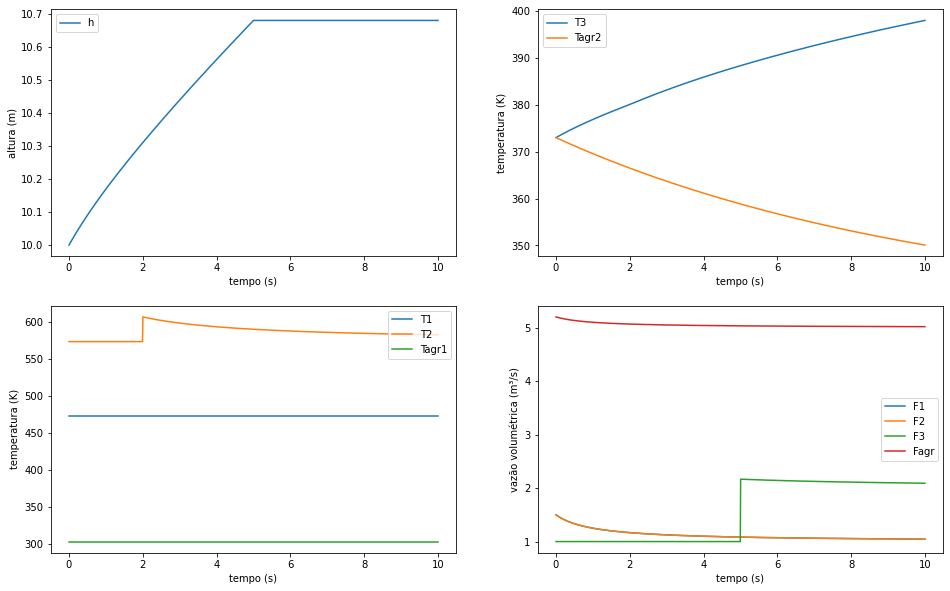

In [647]:
figura = plt.figure(figsize = (16, 10)) #gráficos pelo modelo não linear

grafico1 = figura.add_subplot(2, 2, 1) #plot do gráfico 'altura x tempo'
grafico1.plot(t, h)
grafico1.legend(['h'])
grafico1.set_xlabel('tempo (s)')
grafico1.set_ylabel('altura (m)')

grafico2 = figura.add_subplot(2, 2, 2) #plot do gráfico 'T3 e Tagr2 x tempo'
grafico2.plot(t, T3)
grafico2.plot(t, Tagr2)
grafico2.legend(['T3', 'Tagr2'])
grafico2.set_xlabel('tempo (s)')
grafico2.set_ylabel('temperatura (K)')

grafico3 = figura.add_subplot(2, 2, 3) #comportamento temporal das temperaturas conhecidas (inputs T1, T2 e Tagr1)
grafico3.plot(t, list(map(T1, t)))
grafico3.plot(t, list(map(T2, t)))
grafico3.plot(t, list(map(Tagr1, t)))
grafico3.legend(['T1', 'T2', 'Tagr1'])
grafico3.set_xlabel('tempo (s)')
grafico3.set_ylabel('temperatura (K)')

grafico4 = figura.add_subplot(2, 2, 4) #comportamento temporal das correntes conhecidas (inputs F1, F2 e Fagr)
grafico4.plot(t, list(map(F1, t)))
grafico4.plot(t, list(map(F2, t)))
grafico4.plot(t, list(map(F3, t)))
grafico4.plot(t, list(map(Fagr, t)))
grafico4.legend(['F1', 'F2', 'F3', 'Fagr'])
grafico4.set_xlabel('tempo (s)')
grafico4.set_ylabel('vazão volumétrica (m³/s)')

In [648]:
# funções para construir a segunda ODE linearizada

def c1(i, j, k): #construtor de função 1: i = T, j = F, k = h 
    return i*j/k**2
def c2(i, k):    #construtor de função 2: i = T ou F, k = h 
    return i/k
def c3(k, i = None, j = None):    #construtor de função 3: k = h, i = T3, j = Tagr2 
    if i == None and j == None:
        return U*Att/(k*rho*cp)
    else:
        return U*Att*(i-j)/(k**2*rho*cp)
    
def odes_lineares(p, t):
    h, T3, Tagr2 = p[0], p[1], p[2]
    
    dhdt = (F1(t) + F2(t) - F3(t))/A
    dt3dt = ((1/A)*(h*(c1(T3_s, F1_s, h_s) + c1(T3_s, F2_s, h_s) 
                    - c1(T1_s, F1_s, h_s) - c1(T2_s, F2_s, h_s) + c3(h_s, T3_s, Tagr2_s)) 
               - T3*(c2(F1_s, h_s) + c2(F2_s, h_s) + c3(h_s))
               + Tagr2*c3(h_s)
               + F1(t)*(-c2(T3_s, h_s) + c2(T1_s, h_s))
               + F2(t)*(-c2(T3_s, h_s) + c2(T2_s, h_s))
               + T1(t)*c2(F1_s, h_s) 
               + T2(t)*c2(F2_s, h_s)
              )
            )
    dtagr2dt = (1/vc) * (Fagr(t)*(Tagr1_s-Tagr2_s) + Fagr_s*(Tagr1(t)-Tagr2) + U*Att*(T3-Tagr2)/(rho*cp))  
    
    return [dhdt, dt3dt, dtagr2dt]
    
p = [h_s, T3_s, Tagr2_s] #valores de contorno das variáveis de saída
t = np.linspace(0, 10, 1000)
resultados = odeint(odes_lineares, p, t)
h = resultados[:, 0]
T3 = resultados[:, 1]
Tagr2 = resultados[:, 2]